In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.vision import *
from fastai.metrics import error_rate

from os import path
import boto3
import tarfile

# fastai CNN Training

## Get Data

fastai's `untar_data` doesn't work for file stored in S3 (it seems it can only download data that it has direct access to).

In [5]:
s3 = boto3.client('s3')
data_path = 'data/restaurants.tar.gz'
if not path.exists(data_path):
    s3.download_file('poi-ml', 'fastai/downloads.tar.gz', data_path)
tarfile.open(data_path, 'r:gz').extractall('data')

In [6]:
path = Path('data/downloads/')
path

PosixPath('data/downloads')

## Remove Bad Images

In case some pictures are broken, copy them to a separate folder.

In [35]:
verify_images(path, recurse=True, dest='/tmp/junk', delete=True)
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=224, valid_pct=.2)

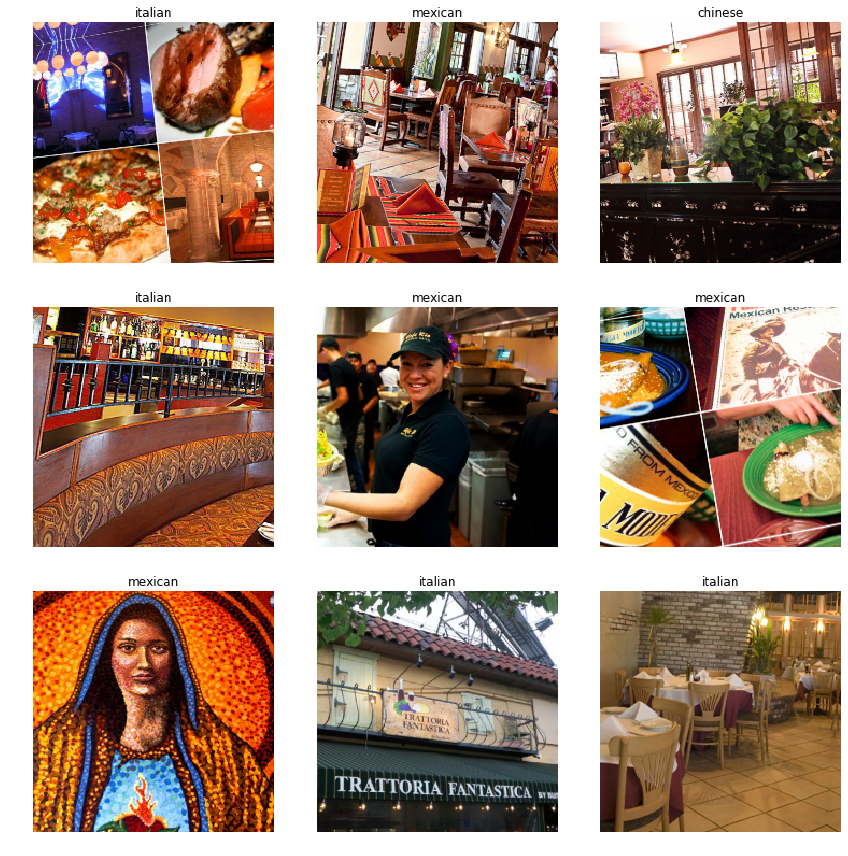

In [36]:
data.show_batch(rows=3, fig_size=(5, 5))

In [37]:
print(data.classes)
len(data.classes),data.c

['chinese', 'italian', 'mexican']


(3, 3)

## Training Using Resnet34

In [38]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [39]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [40]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.243303,0.933277,0.404806,00:16
1,1.107345,0.921847,0.423290,00:16
2,0.980609,0.850774,0.386322,00:16
3,0.908291,0.843799,0.369686,00:16


In [41]:
learn.save('stage-1')

## Analyze

The error rate was around 44% which is crazily high.

In [42]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

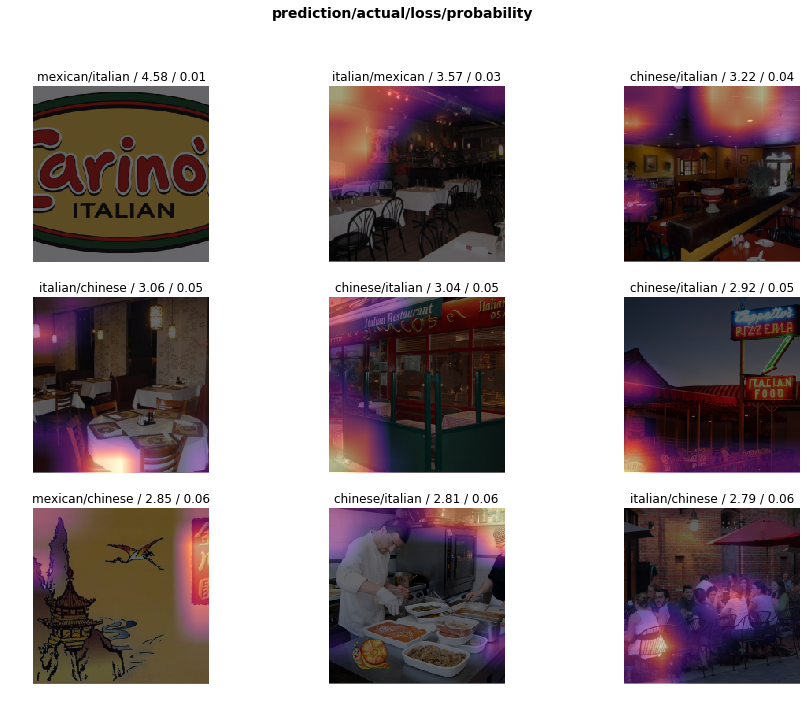

In [43]:
interp.plot_top_losses(9, figsize=(15,11))

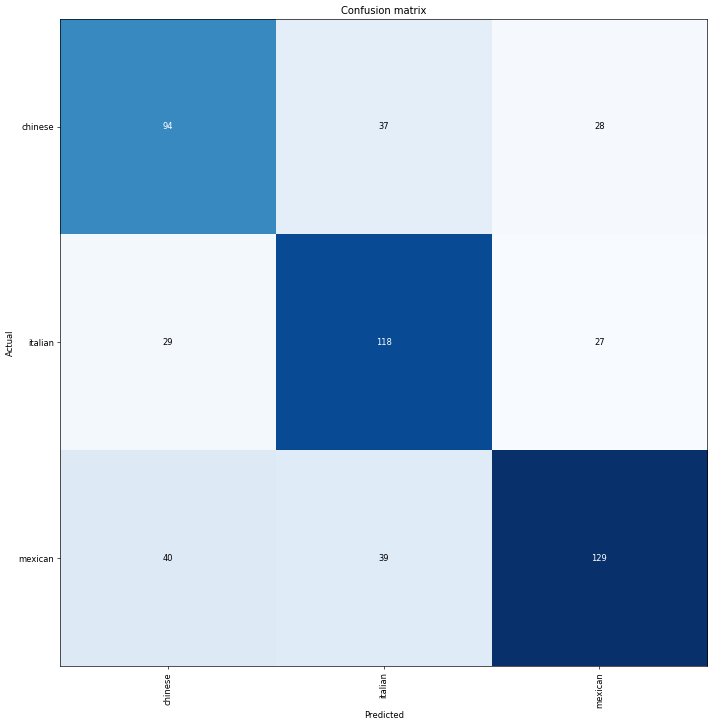

In [44]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

From the top-losses data we can see the our data is not very well-defined, it has dishes, human faces, restaurant internals etc.

In [45]:
interp.most_confused(min_val=2)

[('mexican', 'chinese', 40),
 ('mexican', 'italian', 39),
 ('chinese', 'italian', 37),
 ('italian', 'chinese', 29),
 ('chinese', 'mexican', 28),
 ('italian', 'mexican', 27)]